--- 1. Data Preparation: Loading and Cleaning Data ---
GOAL: Predict the Customer Segment (Occasional, Regular, or Premium) to improve marketing.

Total Customer Records Loaded: 302010
First 2 rows of data (Original):
 Transaction_ID  Customer_ID                Name             Email        Phone            Address       City   State  Zipcode Country  Age Gender Income Customer_Segment       Date   Year     Month     Time  Total_Purchases     Amount  Total_Amount Product_Category Product_Brand Product_Type  Feedback Shipping_Method Payment_Method Order_Status  Ratings       products
      8691788.0      37249.0 Michelle Harrington Ebony39@gmail.com 1414786801.0  3959 Amanda Burgs   Dortmund  Berlin  77985.0 Germany 21.0   Male    Low          Regular  9/18/2023 2023.0 September 22:03:55              3.0 108.028757    324.086270         Clothing          Nike       Shorts Excellent        Same-Day     Debit Card      Shipped      5.0 Cycling shorts
      2174773.0      69749.0         K

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.1 when using version 1.5.1. This might

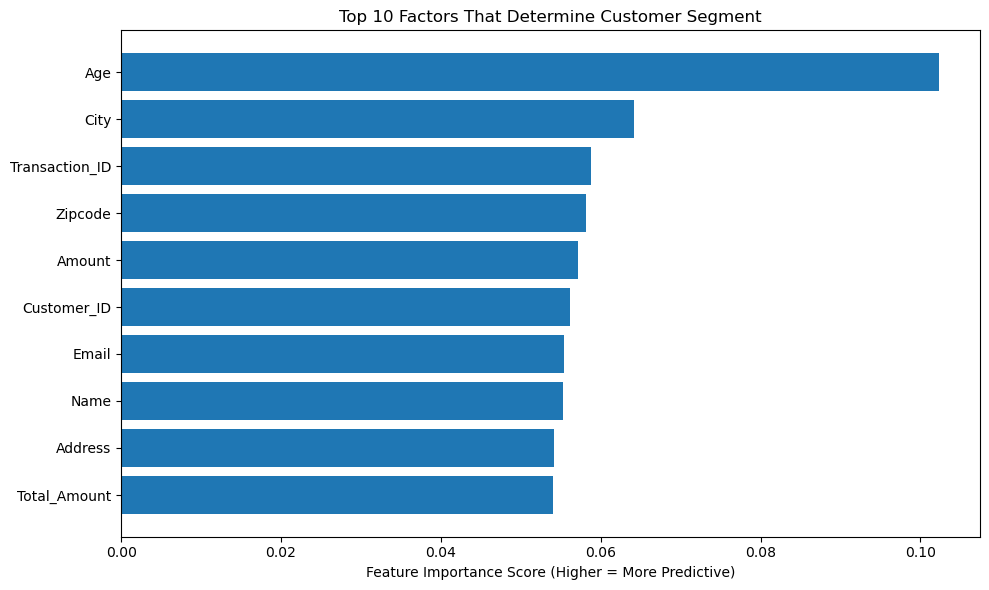

/opt/anaconda3/lib/python3.12/site-packages/gradio/utils.py:1054: UserWarning: Expected 0 arguments for function <function predict_customer_segment at 0x30f4422a0>, received 25.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/gradio/utils.py:1062: UserWarning: Expected maximum 0 arguments for function <function predict_customer_segment at 0x30f4422a0>, received 25.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://dbf6d6187d39e2bcdb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ===========================
# Customer Segment Predictor
# ===========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import gradio as gr
import os
import joblib  # for saving and loading models

# ---------------------------
# 1. Load the data
# ---------------------------

csv_path = "../backend/data.csv"  # in Colab, place data.csv in the same directory
df = pd.read_csv(csv_path)

print("--- 1. Data Preparation: Loading and Cleaning Data ---")
print("GOAL: Predict the Customer Segment (Occasional, Regular, or Premium) to improve marketing.")

print(f"\nTotal Customer Records Loaded: {len(df)}")
print("First 2 rows of data (Original):")
print(df.head(2).to_string(index=False))

# Drop date and time columns
df.drop(columns=['Date', 'Year', 'Month', 'Time'], inplace=True)

# Features and target
TARGET_COL = 'Customer_Segment'
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print(f"\nCustomer Segments to Predict:\n{y.value_counts()}")
print("-" * 50)

# ---------------------------
# 2. Feature Encoding
# ---------------------------

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}

# ---------------------------
# 3. Load or Train Model
# ---------------------------

MODEL_FILE = "rf_customer_segment.joblib"
ENCODER_FILE = "label_encoders.joblib"
TARGET_ENCODER_FILE = "target_encoder.joblib"

if os.path.exists(MODEL_FILE) and os.path.exists(ENCODER_FILE) and os.path.exists(TARGET_ENCODER_FILE):
    print("Loading saved model and encoders...")
    rf_classifier = joblib.load(MODEL_FILE)
    label_encoders = joblib.load(ENCODER_FILE)
    le_target = joblib.load(TARGET_ENCODER_FILE)
else:
    print("Training new model...")

    # encode categorical columns
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    X_encoded = X

    # encode target
    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)
    target_mapping = dict(zip(y_encoded, y))

    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
    )

    rf_classifier = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )

    rf_classifier.fit(X_train, y_train)
    print("Model training complete.")

    # Save the model and encoders
    joblib.dump(rf_classifier, MODEL_FILE)
    joblib.dump(label_encoders, ENCODER_FILE)
    joblib.dump(le_target, TARGET_ENCODER_FILE)
    print("Model and encoders saved for future use.")

# ---------------------------
# 4. Feature Importance (optional visualization)
# ---------------------------

try:
    importances = rf_classifier.feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='#1f77b4')
    plt.xlabel('Feature Importance Score (Higher = More Predictive)')
    plt.title('Top 10 Factors That Determine Customer Segment')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('customer_segment_feature_importance.png')
    plt.show()
except Exception as e:
    print("Skipping feature importance plot:", e)

# ---------------------------
# 5. Gradio Interface
# ---------------------------

def predict_customer_segment(**kwargs):
    # convert input dict to DataFrame
    input_df = pd.DataFrame([kwargs])

    # encode categorical columns using saved LabelEncoders
    for col in categorical_cols:
        if col in input_df:
            le = label_encoders[col]
            input_df[col] = le.transform(input_df[col].astype(str))

    pred_num = rf_classifier.predict(input_df)[0]
    pred_label = le_target.inverse_transform([pred_num])[0]

    return f"Predicted Customer Segment: {pred_label}"

# define gradio input components dynamically
gr_inputs = []
for col in X.columns:
    if col in categorical_cols:
        unique_vals = df[col].dropna().unique().tolist()
        gr_inputs.append(gr.Dropdown(choices=unique_vals, label=col))
    else:
        gr_inputs.append(gr.Number(label=col))

interface = gr.Interface(
    fn=predict_customer_segment,
    inputs=gr_inputs,
    outputs=gr.Textbox(),
    title="Customer Segment Predictor",
    description="Enter customer details to predict their segment (Occasional, Regular, Premium)."
)

interface.launch(share=True)
